In [2]:
import os
import sys
import geopandas as gpd
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import altair as alt
from mpl_toolkits.mplot3d import Axes3D
alt.data_transformers.enable("vegafusion")
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import warnings

warnings.filterwarnings('ignore')

In [3]:
sys.path.append("../../src")
import main

In [4]:
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

In [11]:
# linear regression of ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median'] and 'Temperature_diff_K'

radii = [30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,320,340,360,380,400,450,500,600,700,800,900,1000,1100,1200,1500,2000]

stats = {}

for radius in radii:
    print(radius)
    gdf = gpd.read_parquet('/Users/lisawink/Documents/paper1/data/processed_data/mbike/270623_processed_station_params_' + str(radius) + '.parquet')
    stats[radius] = {}

    for var in ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']:
        print(var)
        # drop nan values
        gdf_s = gdf.dropna(subset=[var, 'Temperature_diff_K'])

        if var in ['BuVol_3D_sum', 'BuEWA_3D_sum', 'BuSWR_3D_median', 'BuHt_wmean', 'BuFra_3D_wmean']:
            gdf_s = gdf_s[gdf_s[var] > 0]

        stats[radius][var+'_std'] = gdf_s[var].std()
        stats[radius][var+'_mean'] = gdf_s[var].mean()
        stats[radius][var+'_CV'] = gdf_s[var].std()/gdf_s[var].mean()

        stats[radius][var+'_spearman_corr'], stats[radius][var+'_spearman_p_value'] = spearmanr(gdf_s[var],gdf_s['Temperature_diff_K'])

        # Pearson and r squared
        stats[radius][var+'_pearson_corr'], stats[radius][var+'_pearson_p_value'] = pearsonr(gdf_s[var], gdf_s['Temperature_diff_K'])
        X = sm.add_constant(gdf_s[var])  # Add constant for regression
        model = sm.OLS(gdf_s['Temperature_diff_K'], X).fit()
        r_squared = model.rsquared
        stats[radius][var+'_rsquared'] = r_squared

        # Get the predicted values (fitted values)
        y_pred = model.fittedvalues

        # Calculate the residuals (errors)
        residuals = gdf_s['Temperature_diff_K'] - y_pred

        # Calculate the least squares error (RSS)
        rss = np.sum(residuals ** 2)
        # Calculate the Mean Squared Error (MSE)
        mse = rss / len(gdf_s[var])
        # Calculate the Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mse)
        stats[radius][var+'_rmse'] = rmse

        # Compute Cook's distance
        influence = model.get_influence()
        cooks_d = influence.cooks_distance[0].max()  # Max Cook's distance
        stats[radius][var+'_cooks_d'] = cooks_d

    # Multiple Linear Regression
    stn_nona = gdf.dropna(subset=params)
    X = stn_nona[params]
    y = stn_nona['Temperature_diff_K']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # perform linear regression
    X_train = sm.add_constant(X_train)  # Add constant for regression
    model = sm.OLS(y_train, X_train).fit()
    stats[radius]['MLR_rsquared'] = model.rsquared
    stats[radius]['MLR_fvalue'] = model.fvalue
    stats[radius]['MLR_f_pvalue'] = model.f_pvalue

    # print r squared for test set
    X_test = sm.add_constant(X_test)  # Add constant for regression
    y_pred = model.predict(X_test)
    r2_MLR = 1 - sum((y_test - y_pred)**2) / sum((y_test - np.mean(y_test))**2)
    stats[radius]['MLR_test_rsquared'] = r2_MLR

    # Lasso regression
    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train, y_train)

    y_pred = lasso.predict(X_test)
    r2_lasso = 1 - sum((y_test - y_pred)**2) / sum((y_test - np.mean(y_test))**2)
    stats[radius]['lasso_rsquared'] = r2_lasso
    
pd.DataFrame(stats).T.to_csv('/Users/lisawink/Documents/paper1/data/processed_data/mbike/270623_stats_scales.csv')

30
BuAre_sum
BuVol_3D_sum
BuEWA_3D_sum
BuIBD
BuAdj
BuSWR_3D_median
BuHt_wmean
StrHW_median
SVF_3D_mean
BuSqC_wmean
BuFra_3D_wmean
StrClo400_median
40
BuAre_sum
BuVol_3D_sum
BuEWA_3D_sum
BuIBD
BuAdj
BuSWR_3D_median
BuHt_wmean
StrHW_median
SVF_3D_mean
BuSqC_wmean
BuFra_3D_wmean
StrClo400_median
50
BuAre_sum
BuVol_3D_sum
BuEWA_3D_sum
BuIBD
BuAdj
BuSWR_3D_median
BuHt_wmean
StrHW_median
SVF_3D_mean
BuSqC_wmean
BuFra_3D_wmean
StrClo400_median
60
BuAre_sum
BuVol_3D_sum
BuEWA_3D_sum
BuIBD
BuAdj
BuSWR_3D_median
BuHt_wmean
StrHW_median
SVF_3D_mean
BuSqC_wmean
BuFra_3D_wmean
StrClo400_median
70
BuAre_sum
BuVol_3D_sum
BuEWA_3D_sum
BuIBD
BuAdj
BuSWR_3D_median
BuHt_wmean
StrHW_median
SVF_3D_mean
BuSqC_wmean
BuFra_3D_wmean
StrClo400_median
80
BuAre_sum
BuVol_3D_sum
BuEWA_3D_sum
BuIBD
BuAdj
BuSWR_3D_median
BuHt_wmean
StrHW_median
SVF_3D_mean
BuSqC_wmean
BuFra_3D_wmean
StrClo400_median
90
BuAre_sum
BuVol_3D_sum
BuEWA_3D_sum
BuIBD
BuAdj
BuSWR_3D_median
BuHt_wmean
StrHW_median
SVF_3D_mean
BuSqC_wmean
BuF

In [12]:
df = pd.DataFrame(stats).T

In [8]:
df = pd.read_csv('/Users/lisawink/Documents/paper1/data/processed_data/mbike/270623_stats_scales.csv', index_col=0)

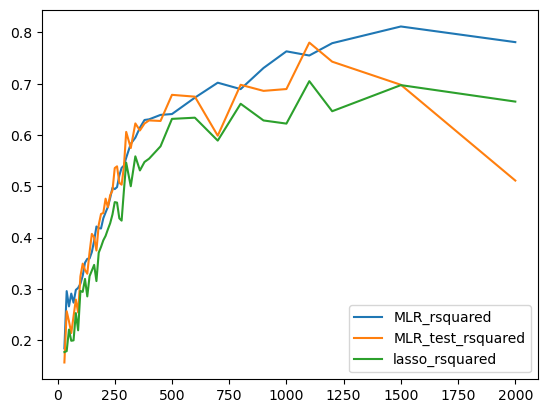

In [15]:
plt.plot(df.index, df['MLR_rsquared'], label='MLR_rsquared')
plt.plot(df.index, df['MLR_test_rsquared'], label='MLR_test_rsquared')
plt.plot(df.index, df['lasso_test_rsquared'], label='lasso_rsquared')
plt.legend()

In [9]:
df

,BuAre_sum_std,BuAre_sum_mean,BuAre_sum_CV,BuAre_sum_spearman_corr,BuAre_sum_spearman_p_value,BuAre_sum_pearson_corr,BuAre_sum_pearson_p_value,BuAre_sum_rsquared,BuAre_sum_rmse,BuAre_sum_cooks_d,...,StrClo400_median_pearson_corr,StrClo400_median_pearson_p_value,StrClo400_median_rsquared,StrClo400_median_rmse,StrClo400_median_cooks_d,MLR_rsquared,MLR_fvalue,MLR_f_pvalue,MLR_test_rsquared,lasso_rsquared
30,369.092412,5.535170e+02,0.666813,0.298861,4.952704e-62,0.297440,1.965044e-61,0.088470,1.457113,0.048260,...,0.329324,1.308855e-34,0.108454,1.389481,0.011331,0.184085,1.616930,1.017862e-01,0.156512,0.176831
40,621.440735,9.167130e+02,0.677901,0.324420,5.904998e-92,0.328104,3.919041e-94,0.107652,1.465382,0.035366,...,0.308889,9.517104e-48,0.095412,1.363589,0.008351,0.295659,19.134364,7.429632e-35,0.256460,0.178623
50,987.586272,1.409903e+03,0.700464,0.357863,3.536615e-125,0.356919,1.754599e-124,0.127391,1.461658,0.023638,...,0.324765,7.642486e-67,0.105473,1.418970,0.006266,0.265906,33.113287,1.342457e-65,0.237012,0.220622
60,1385.522911,2.016837e+03,0.686978,0.382237,3.044619e-153,0.381986,4.998481e-153,0.145913,1.444983,0.023912,...,0.323398,7.466847e-77,0.104586,1.419639,0.005639,0.290815,54.094891,4.191909e-109,0.213860,0.198837
70,1882.435569,2.732523e+03,0.688900,0.411989,3.405684e-188,0.404527,7.059142e-181,0.163642,1.456130,0.007474,...,0.313746,6.318689e-80,0.098437,1.413832,0.005722,0.273213,63.248503,1.683807e-130,0.246442,0.199667
80,2411.193329,3.573560e+03,0.674732,0.452406,1.117164e-236,0.442577,2.061579e-225,0.195875,1.440190,0.010303,...,0.314663,1.720372e-86,0.099013,1.426641,0.005113,0.298014,83.950974,2.195278e-172,0.279191,0.252783
90,3055.675505,4.536038e+03,0.673644,0.491599,2.337367e-291,0.475967,1.033916e-270,0.226544,1.430608,0.009079,...,0.318648,5.203849e-94,0.101536,1.437332,0.005223,0.301916,95.076416,1.106963e-195,0.253927,0.219267
100,3783.029271,5.622681e+03,0.672816,0.512764,0.000000e+00,0.493494,5.347702e-298,0.243536,1.418785,0.010638,...,0.314822,4.223386e-96,0.099113,1.450743,0.004993,0.309973,105.940608,1.364493e-217,0.324531,0.295898
110,4529.780164,6.759867e+03,0.670099,0.532891,0.000000e+00,0.510434,0.000000e+00,0.260543,1.410785,0.010639,...,0.317061,1.026506e-101,0.100528,1.449538,0.005128,0.325488,119.793917,4.326333e-244,0.349257,0.294097
120,5329.109252,8.018272e+03,0.664621,0.550614,0.000000e+00,0.529498,0.000000e+00,0.280368,1.401107,0.008478,...,0.322311,4.229219e-108,0.103884,1.456081,0.005341,0.351119,139.787902,2.900353e-280,0.336719,0.319420


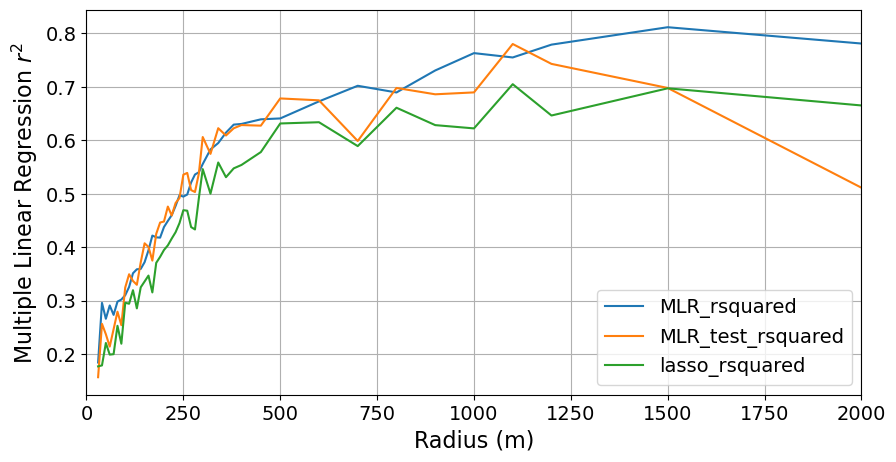

In [19]:
plt.figure(figsize=(10,5))
plt.plot(df.index, df['MLR_rsquared'], label='MLR_rsquared')
plt.plot(df.index, df['MLR_test_rsquared'], label='MLR_test_rsquared')
plt.plot(df.index, df['lasso_rsquared'], label='lasso_rsquared')
plt.grid()
plt.xlabel('Radius (m)',fontsize=16)
plt.ylabel('Multiple Linear Regression $r^2$',fontsize=16)
plt.xlim(0,2000)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=14)
plt.savefig('/Users/lisawink/Documents/paper1/figures/MLR_rsquared.png', dpi=300)
plt.show()

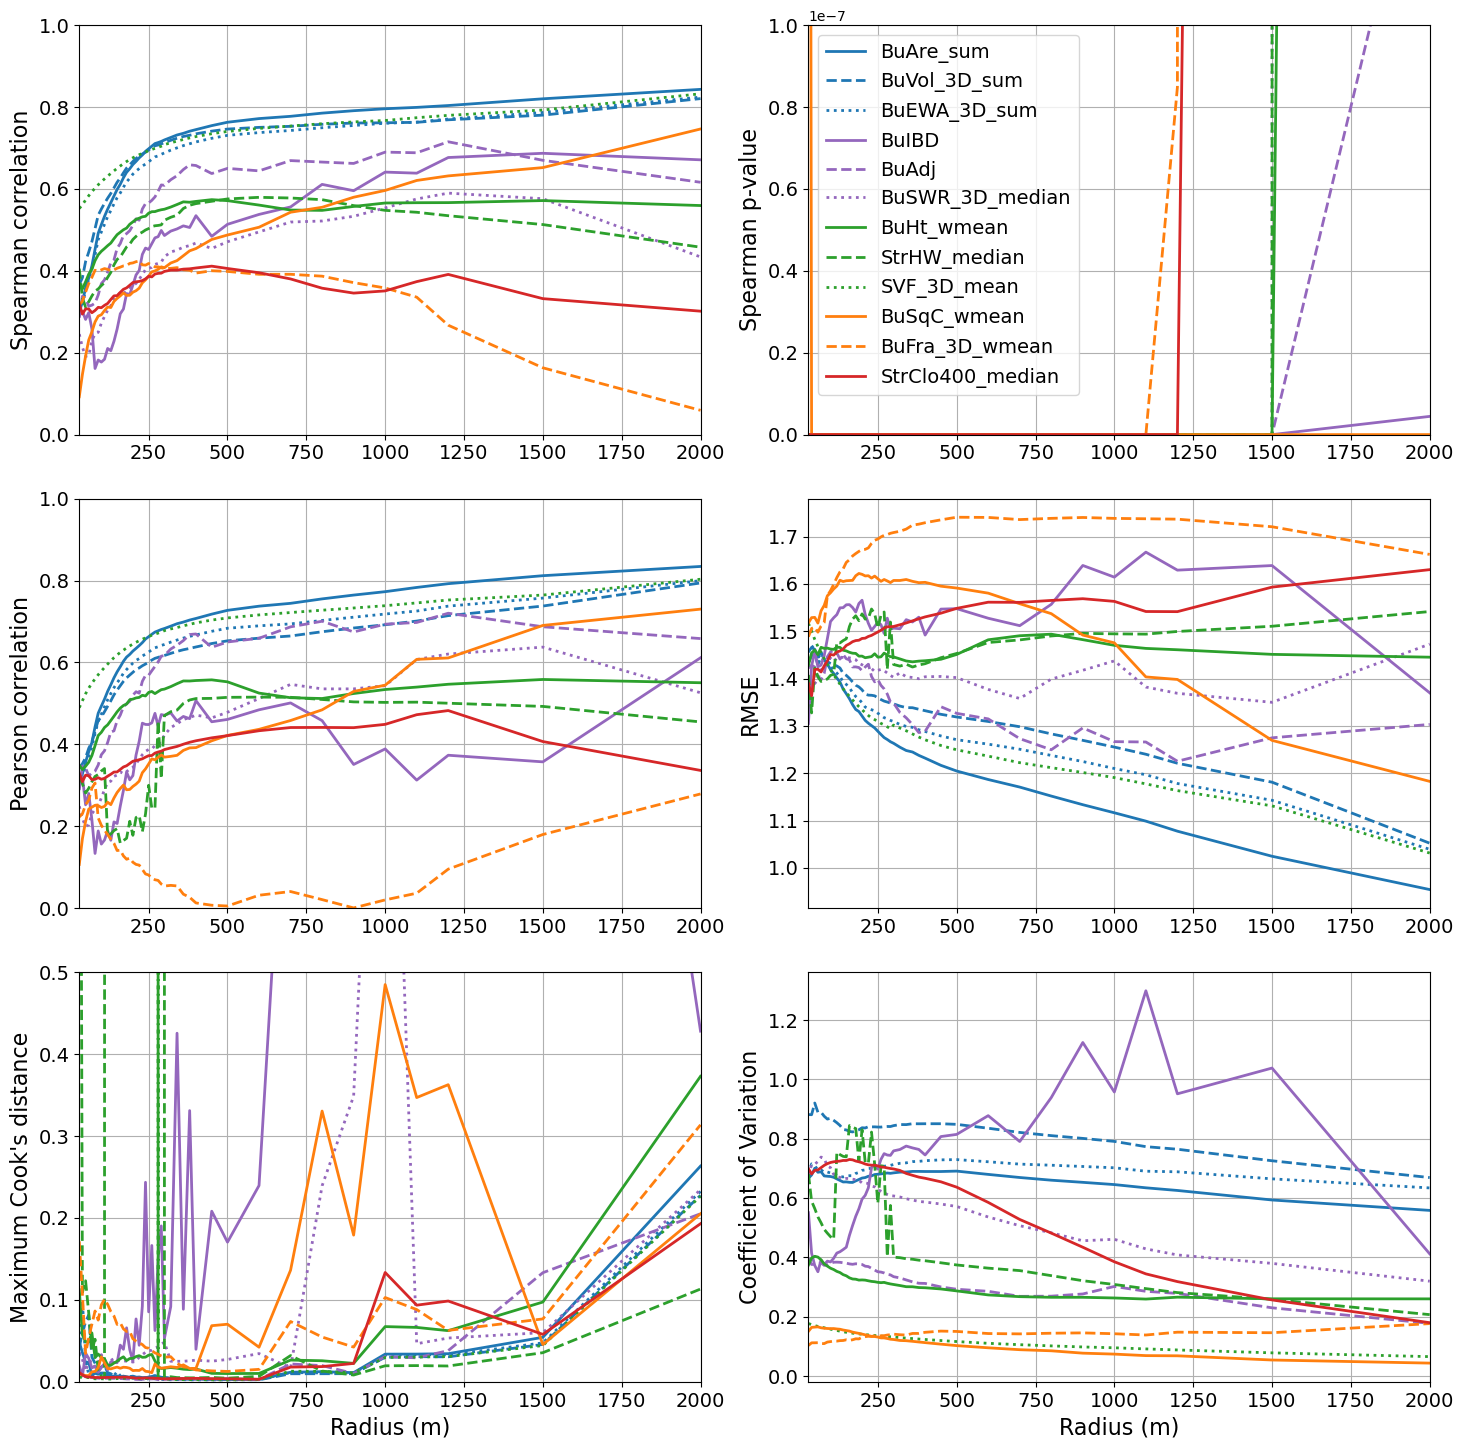

In [7]:
df = pd.DataFrame(stats).T
fig, axs = plt.subplots(3,2, figsize=(15, 15))

linestyle_mapping = {
    'BuAre_sum': '-',
    'BuVol_3D_sum': '--',
    'BuEWA_3D_sum': ':',
    'BuIBD':'-',
    'BuAdj':'--',
    'BuSWR_3D_median':':',
    'BuHt_wmean': '-',
    'StrHW_median': '--',
    'SVF_3D_mean': ':',
    'BuSqC_wmean': '-',
    'BuFra_3D_wmean': '--',
    'StrClo400_median': '-'
}

color_mapping = {
    'BuAre_sum': 'tab:blue',
    'BuVol_3D_sum': 'tab:blue',
    'BuEWA_3D_sum': 'tab:blue',
    'BuIBD':'tab:purple',
    'BuAdj':'tab:purple',
    'BuSWR_3D_median':'tab:purple',
    'BuHt_wmean': 'tab:green',
    'StrHW_median': 'tab:green',
    'SVF_3D_mean': 'tab:green',
    'BuSqC_wmean': 'tab:orange',
    'BuFra_3D_wmean': 'tab:orange',
    'StrClo400_median': 'tab:red'
}

for var in params:
    axs[0, 0].plot(abs(df[var+'_spearman_corr']), label=var, linestyle=linestyle_mapping[var], linewidth=2, color=color_mapping[var])
axs[0, 0].set_ylabel('Spearman correlation', fontsize=16)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xlim(30, 2000)
#axs[0, 0].set_xticklabels([])
axs[0, 0].tick_params(axis='both', which='major', labelsize=14)
axs[0, 0].grid()

for var in params:
    axs[0, 1].plot(df[var+'_spearman_p_value'], label=var, linestyle=linestyle_mapping[var], linewidth=2, color=color_mapping[var])
axs[0, 1].set_ylabel("Spearman p-value", fontsize=16)
axs[0, 1].legend(prop={'size': 14})
axs[0, 1].set_ylim(0, 0.0000001)
axs[0, 1].set_xlim(30, 2000)
#axs[0, 1].set_xticklabels([])
axs[0, 1].tick_params(axis='both', which='major', labelsize=14)
axs[0, 1].grid()

for var in params:
    axs[1, 0].plot(abs(df[var+'_pearson_corr']), label=var, linestyle=linestyle_mapping[var], linewidth=2,color=color_mapping[var])
axs[1, 0].set_ylabel('Pearson correlation', fontsize=16)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlim(30, 2000)
#axs[1, 0].set_xticklabels([])
axs[1, 0].tick_params(axis='both', which='major', labelsize=14)
axs[1, 0].grid()

for var in params:
    axs[1, 1].plot(df[var+'_rmse'], label=var, linestyle=linestyle_mapping[var],linewidth=2, color=color_mapping[var])
axs[1, 1].set_ylabel('RMSE', fontsize=16)
axs[1, 1].grid()
#axs[1, 1].set_ylim(0.5, 1.1)
axs[1, 1].set_xlim(30, 2000)
#axs[1, 1].set_xticklabels([])
axs[1, 1].tick_params(axis='both', which='major', labelsize=14)

for var in params:
    axs[2, 0].plot(df[var+'_cooks_d'], label=var, linestyle=linestyle_mapping[var],linewidth=2, color=color_mapping[var])
axs[2, 0].set_ylabel("Maximum Cook's distance", fontsize=16)
axs[2, 0].set_ylim(0, 0.5)
axs[2, 0].set_xlim(30, 2000)
axs[2, 0].set_xlabel('Radius (m)', fontsize=16)
axs[2, 0].tick_params(axis='both', which='major', labelsize=14)
axs[2, 0].grid()

for var in params:
    axs[2, 1].plot(df[var+'_CV'], label=var, linestyle=linestyle_mapping[var],linewidth=2, color=color_mapping[var])
axs[2, 1].set_ylabel("Coefficient of Variation", fontsize=16)
#axs[2, 1].set_ylim(0, 2)
axs[2, 1].set_xlim(30, 2000)
axs[2, 1].set_xlabel('Radius (m)', fontsize=16)
axs[2, 1].tick_params(axis='both', which='major', labelsize=14)
axs[2, 1].grid()

plt.tight_layout(pad = 2, w_pad=1)
plt.savefig('/Users/lisawink/Documents/paper1/figures/mbike270623_param_scale_plot_featured_list.png')
plt.savefig('/Users/lisawink/Documents/paper1/figures/mbike270623_param_scale_plot_featured_list.pdf')
plt.show()

2000


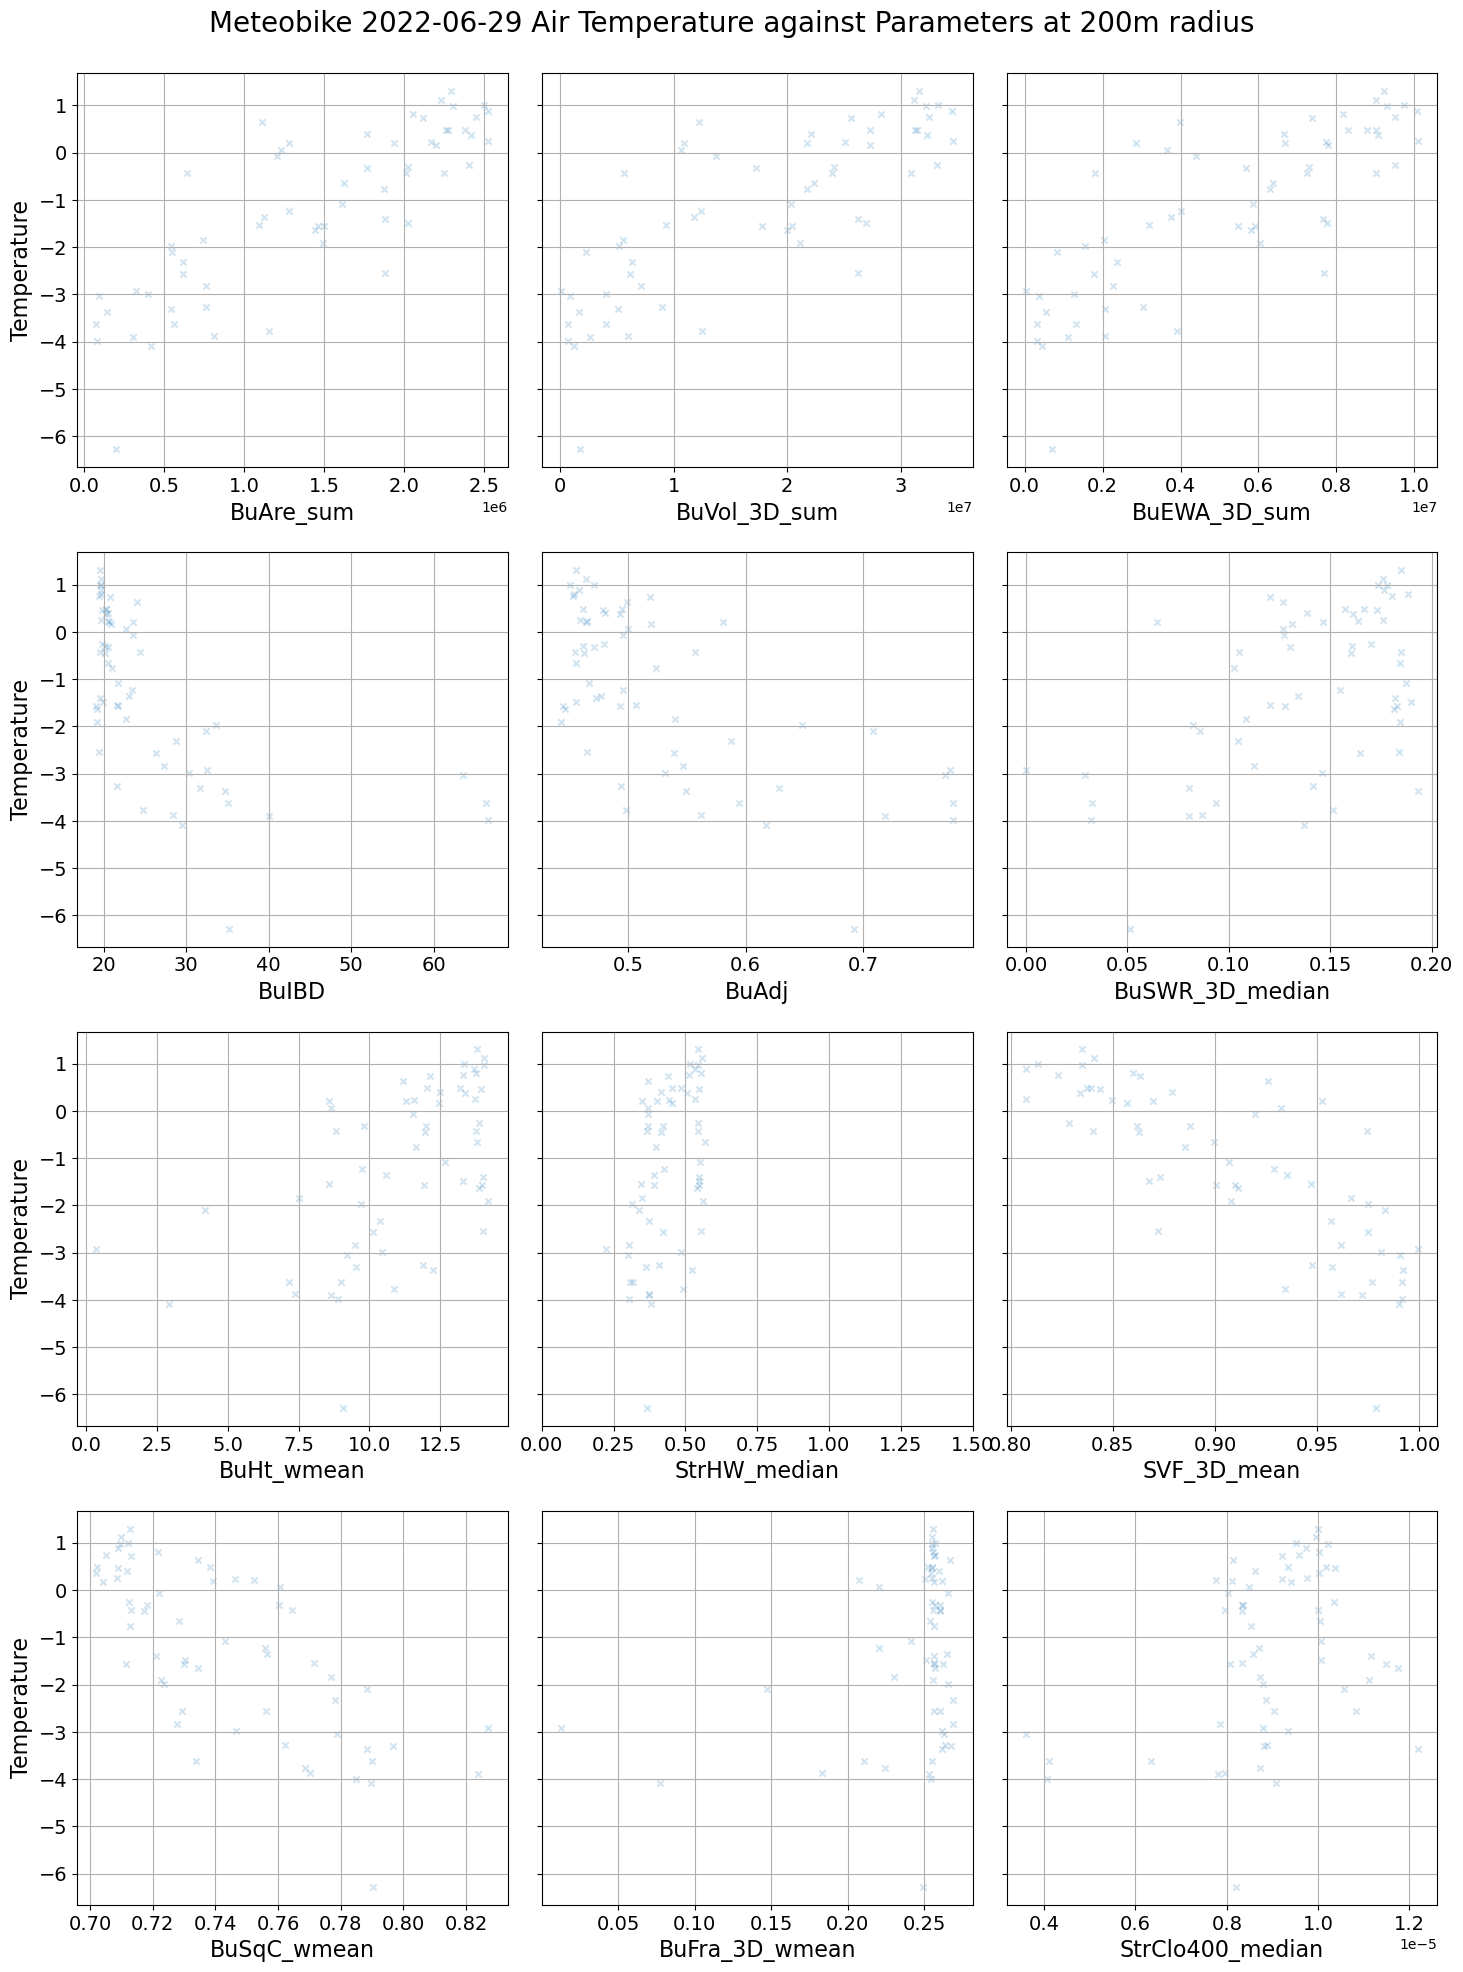

In [8]:
radii = [2000]

spearman_corr = {}

for radius in radii:
    print(radius)
    stn_buffers = gpd.read_parquet('/Users/lisawink/Documents/paper1/data/processed_data/mbike/270623_processed_station_params_' + str(radius) + '.parquet')
    spearman_corr[radius] = {}

    fig, axs = plt.subplots(4, 3, figsize=(15, 20))
    fig.suptitle('Meteobike 2022-06-29 Air Temperature against Parameters at 200m radius', fontsize=20, y=0.99)
    #fig.subplots_adjust(wspace=0.1)
    for i, ax in enumerate(axs.flat):
        if params[i] == 'StrHW_median':
            stn_buffers[['StrHW_median','Temperature_diff_K']].plot(x='StrHW_median', y='Temperature_diff_K', ax=ax, kind='scatter',marker='x',xlim=(0,1.5),alpha=0.2)
        else:
            stn_buffers[[params[i],'Temperature_diff_K']].plot(x=params[i], y='Temperature_diff_K', ax=ax, kind='scatter',marker='x',alpha=0.2)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_xlabel(params[i],fontsize=16)
        ax.set_ylabel('Temperature',fontsize=16)
        ax.grid()

        if i % 3 != 0:  # 1st column (index 0, 3, 6, ...) keeps labels
            ax.set_ylabel("")  # Remove y-axis label
            ax.yaxis.set_ticklabels([])  # Remove y-axis ticks
            
    plt.tight_layout(pad = 2, w_pad=0.01)